<a href="https://colab.research.google.com/github/jerry26432341/myTheses/blob/main/d2v_randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas matplotlib jieba scikit-learn gensim jieba testfixtures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 KB 5.6 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import jieba as jb
import re
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from google.colab import drive

# 掛載Google Drive
drive.mount('/content/drive')

# 讀取CSV檔案
df = pd.read_csv('/content/drive/MyDrive/shopping.csv')
df=df[['cat','review']]
print("数据总量: %d ." % len(df))
df.sample(10)


Mounted at /content/drive
数据总量: 62774 .


,cat,review
25322,水果,没吃过这么难吃的火龙果，酸死了，一般我是不评论的，今天是受不了?
59957,酒店,淋浴室玻璃老化，两边底部都漏水，差点摔死。
31678,洗发水,假的，洗了头发更油，超级差 本来觉得挺好的牌子想尝试一下，垃圾
34048,洗发水,简直就是垃圾，开口撒了一纸箱，垃圾京东
29581,洗发水,京东上的活动，到了年中都会购些囤起来，价格实惠。
13922,手机,支持TV-OUT视频输出；屏幕面积很大；MP3功能出色，并且支持后台播放；拥有128M的内存。
24582,水果,第一次给满星！这次购买就有点伤心了！太小！还有一个坏了
16453,水果,苹果感觉还可以吧，不过觉得跟平时买的差别不大啊？！！中评吧！
40731,衣服,裤子穿着很舒服而且显得腿长。洗了一下也没什么褪**况，真的是五星好评！！！物流快卖家服务态度也好评
13165,平板,一直用华为的手机 平板虽然只要1000 但是也没想会垃圾到这种程度 垃圾中的战斗机 分辨率超...


In [ ]:
print("在 cat 列中总共有 %d 个空值." % df['cat'].isnull().sum())
print("在 review 列中总共有 %d 个空值." % df['review'].isnull().sum())
df[df.isnull().values==True]
df = df[pd.notnull(df['review'])]
df = df.reset_index(drop=True)

在 cat 列中总共有 0 个空值.
在 review 列中总共有 1 个空值.


   cat  count
0   平板  10000
1   水果  10000
2  洗发水  10000
3   衣服  10000
4   酒店  10000
5  计算机   3992
6   书籍   3851
7   手机   2323
8   蒙牛   2033
9  热水器    574


Text(0.5, 0, '類目')

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) m

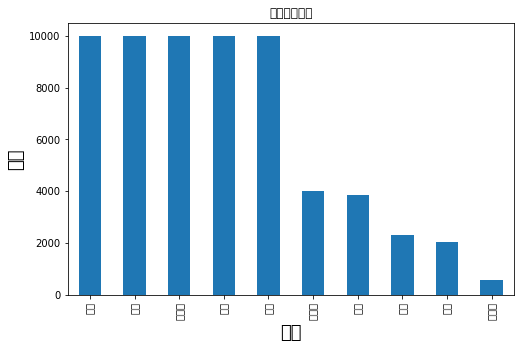

In [ ]:
d = {'cat':df['cat'].value_counts().index, 'count': df['cat'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
print(df_cat)

df_cat.plot(x='cat', y='count', kind='bar', legend=False,  figsize=(8, 5))
plt.title("類目数量分布")
plt.ylabel('數量', fontsize=18)
plt.xlabel('類目', fontsize=18)

In [ ]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line

#停用词列表
def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

#加载停用词
stopwords = stopwordslist('/content/drive/MyDrive/chineseStopWords.txt')

#删除除字母,数字，汉字以外的所有符号
df['clean_review'] = df['review'].apply(remove_punctuation)

#分词，并过滤停用词
# df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df['cut_review'] = df['clean_review'].apply(lambda x: [w for w in list(jb.cut(x)) if w not in stopwords])
df.head()

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.837 seconds.
DEBUG:jieba:Loading model cost 1.837 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,cat,review,clean_review,cut_review
0,书籍,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...,做父母一定要有刘墉这样的心态不断地学习不断地进步不断地给自己补充新鲜血液让自己保持一颗年轻的...,"[做, 父母, 一定, 刘墉, 心态, 不断, 学习, 不断, 进步, 不断, 补充, 新鲜..."
1,书籍,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,作者真有英国人严谨的风格提出观点进行论述论证尽管本人对物理学了解不深但是仍然能感受到真理的火...,"[作者, 真有, 英国人, 严谨, 风格, 提出, 观点, 进行, 论述, 论证, 物理学,..."
2,书籍,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点为什么荷兰曾经县有欧洲最高的生产率...,"[作者, 长篇大论, 借用, 详细, 报告, 数据处理, 工作, 计算结果, 支持, 其新,..."
3,书籍,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,作者在战几时之前用了拥抱令人叫绝日本如果没有战败就有会有美军的占领没胡官僚主义的延续没有战后...,"[作者, 战, 之前, 拥抱, 令人, 叫绝, 日本, 没有, 战败, 会, 美军, 占领,..."
4,书籍,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,作者在少年时即喜阅读能看出他精读了无数经典因而他有一个庞大的内心世界他的作品最难能可贵的有两...,"[作者, 少年, 时即, 喜, 阅读, 看出, 精读, 无数, 经典, 一个, 庞大, 内心..."


In [ ]:
#创建训练集和测试集
train, test = train_test_split(df, test_size=0.3, random_state=42,stratify = df.cat.values)

#创建标签化文档
train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['cut_review'], tags=[r['cat']]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['cut_review'], tags=[r['cat']]), axis=1)

In [ ]:
#CPU内核数
cores = multiprocessing.cpu_count()

In [ ]:
from gensim.models import Doc2Vec
from tqdm import tqdm

model_dbow = Doc2Vec(dm=0,  negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 43941/43941 [00:00<00:00, 2529326.60it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 43941/43941 [00:00<00:00, 2317417.70it/s]


CPU times: user 1min 49s, sys: 7.97 s, total: 1min 57s
Wall time: 1min 28s


In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 初始化模型
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# 在訓練資料上訓練模型
rf.fit(X_train, y_train)

# 在測試資料上進行預測
y_pred = rf.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.3644859813084112
Testing F1 score: 0.3465912628348911


In [ ]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 43941/43941 [00:00<00:00, 620355.08it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 43941/43941 [00:00<00:00, 2299519.79it/s]


CPU times: user 3min 39s, sys: 31.3 s, total: 4min 10s
Wall time: 3min 19s


In [ ]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.3619371282922685
Testing F1 score: 0.31844152683154253


In [ ]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [ ]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [ ]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.39177994902293967
Testing F1 score: 0.36403333988613323
